In [1]:
setwd("/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts")
suppressPackageStartupMessages(library(tximeta))
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(source("tree_helper_function.R"))
# metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505/SRR_Acc_List.txt")
# quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
# samples <- metaData$RUN
# files <- file.path(quantDir, samples, "quant.sf")
# colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
# seMuscle <- tximeta::tximeta(colData)
# save(seMuscle, file="environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/seMuscle.RData")
# mapDf <- data.frame(gene = unlist(rowData(seMuscle)[["gene_id"]]), txp=rownames(seMuscle), ind=seq(nrow(seMuscle)))
# rownames(mapDf) <- mapDf[["txp"]]
# save(mapDf, file = "environment/real_datasets/GSE100505/mapDf.RData")
load("environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/seMuscle.RData")

In [27]:
dds <- DESeqDataSet(seMuscle, design=~condition)
dds <- estimateSizeFactors(dds)
dds <- dds[rowSums(assays(seMuscle)[["counts"]]) > 10,]
vsd <- vst(dds)


using counts and average transcript lengths from tximeta

Warning message in DESeqDataSet(seMuscle, design = ~condition):
"some variables in design formula are characters, converting to factors"
using 'avgTxLength' from assays(dds), correcting for library size



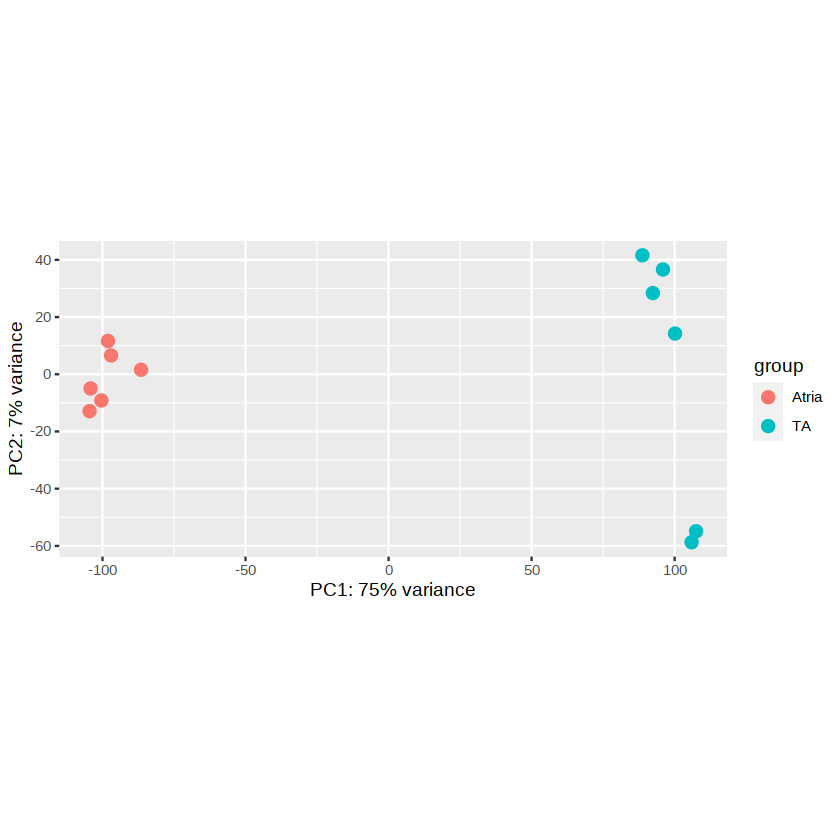

In [28]:
plotPCA(vsd, intgroup=c("condition"), ntop=1000)

In [7]:
trees <- read.tree("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/no_threshold/cluster_nwk.txt")
length(trees)
table(sapply(trees, function(tr) length(tr$tip)))
sum(sapply(trees, function(tr) length(tr$tip)))

[1] 14639


   2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17 
3863 2155 1671 1444 1168  937  698  538  455  343  293  214  157  118   83   82 
  18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33 
  69   58   40   24   22   32   19   19   19    7    8    9    7    7    5    5 
  34   35   36   37   38   39   40   41   42   43   44   45   46   47   49   51 
   4    4    3    1    3    2    3    3    1    2    1    2    3    2    2    1 
  53   55   56   57   60   64   66   68   69   73   76   77   78   83   85   90 
   1    3    1    2    2    1    1    2    1    1    1    1    1    1    1    1 
  97  107  130  136  138  174  237  292  392 2542 
   2    1    2    1    1    1    1    1    1    1 

[1] 88494

In [8]:
tree <- mergeTree(trees, se = seMuscle)
y <- scaleInfReps(seMuscle)
y <- labelKeep(y)
y <- runSwishTree(tree, y, type = "union")
modOb <- mergeLeaves(tree, y)
tree <- modOb[["tree"]]
y <- modOb[["ySwish"]]

[1] "Missing txps 4911"


In [9]:
yNS <- seMuscle[tree$tip,]
yNS <- computeInfRV(yNS, meanVariance = F)
yNSAgg <- prepSwish(tree = tree, seObLeaves = yNS)

In [10]:
save(tree, file="environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/tree.RData")
save(yNS, file="environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/yNS.RData")
save(yNSAgg, file="environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/yNSAgg.RData")

In [ ]:
gseMuscle <- summarizeToGene(seMuscle)
save(gseMuscle, file = "environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/gseMuscle.RData")

In [25]:
infRepIdx <- grep("infRep", assayNames(seMuscle))
infReps <- assays(seMuscle)[infRepIdx]
sfTxps <- cbind(sapply(infReps, estimateSizeFactorsForMatrix), counts = estimateSizeFactorsForMatrix(assays(seMuscle)[["counts"]]))

In [27]:
infRepIdx <- grep("infRep", assayNames(gseMuscle))
infReps <- assays(gseMuscle)[infRepIdx]
sfGenes <- cbind(sapply(infReps, estimateSizeFactorsForMatrix), counts = estimateSizeFactorsForMatrix(assays(gseMuscle)[["counts"]]))

In [38]:
sum(rowVars(sfGenes[,1:100]) < rowVars(sfTxps[,1:100]))
sum(rowVars(sfGenes[,1:100]) > rowVars(sfTxps[,1:100]))

[1] 9

[1] 3

In [39]:
rowVars(sfGenes[,1:100])
rowVars(sfTxps[,1:100])

[1] 1.228826e-05 1.412715e-05 6.515544e-06 1.378502e-05 9.354932e-06
 [6] 9.267420e-06 5.683244e-06 9.239026e-06 5.336192e-06 5.069280e-06
[11] 5.944360e-06 6.452616e-06

[1] 1.890716e-05 2.062841e-05 1.020799e-05 1.372276e-05 1.092581e-05
 [6] 1.030686e-05 4.655953e-06 6.043306e-06 7.978838e-06 6.876026e-06
[11] 6.576166e-06 9.269586e-06

In [47]:
apply(sfTxps,1, sd)
apply(sfGenes,1, sd)

SRR5758624  SRR5758625  SRR5758626  SRR5758627  SRR5758628  SRR5758629 
0.017527613 0.016933083 0.016030302 0.017599718 0.016555557 0.019197242 
 SRR5758707  SRR5758706  SRR5758705  SRR5758704  SRR5758703  SRR5758702 
0.002383458 0.004423396 0.005099128 0.005050583 0.003051881 0.006015289

SRR5758624  SRR5758625  SRR5758626  SRR5758627  SRR5758628  SRR5758629 
0.003487905 0.004134683 0.003103124 0.003710559 0.003331853 0.003820100 
 SRR5758707  SRR5758706  SRR5758705  SRR5758704  SRR5758703  SRR5758702 
0.005102587 0.004649928 0.003090676 0.003560306 0.003377657 0.004023909

In [44]:
apply(sfTxps,1, summary)

,SRR5758624,SRR5758625,SRR5758626,SRR5758627,SRR5758628,SRR5758629,SRR5758707,SRR5758706,SRR5758705,SRR5758704,SRR5758703,SRR5758702
Min.,1.195464,1.359367,0.947022,1.219559,1.050233,0.9621341,0.7189183,0.8095969,1.096815,1.028772,0.9607169,1.060046
1st Qu.,1.363960,1.519496,1.102636,1.390013,1.211092,1.1498695,0.7232621,0.8141684,1.137808,1.070591,0.9754950,1.110423
Median,1.365998,1.523634,1.104948,1.392639,1.213280,1.1525256,0.7244143,0.8158776,1.139701,1.072072,0.9772695,1.112057
Mean,1.364473,1.521746,1.103361,1.390799,1.211683,1.1504908,0.7246745,0.8161687,1.139150,1.071802,0.9773776,1.111756
3rd Qu.,1.369133,1.526707,1.106456,1.395573,1.215446,1.1546118,0.7260903,0.8172492,1.141506,1.073667,0.9794895,1.114160
Max.,1.379030,1.533926,1.112088,1.399211,1.224429,1.1603763,0.7349744,0.8528416,1.147148,1.080233,0.9842880,1.118589


In [45]:
apply(sfGenes,1, summary)

,SRR5758624,SRR5758625,SRR5758626,SRR5758627,SRR5758628,SRR5758629,SRR5758707,SRR5758706,SRR5758705,SRR5758704,SRR5758703,SRR5758702
Min.,1.197916,1.344618,0.9402060,1.232167,1.047814,0.9753492,0.6973737,0.8157615,1.065962,0.992423,0.9204169,1.025260
1st Qu.,1.206238,1.352689,0.9562991,1.238328,1.059573,0.9969088,0.7409609,0.8487536,1.085174,1.018736,0.9425438,1.054930
Median,1.208454,1.355042,0.9580173,1.240544,1.061713,0.9985467,0.7427310,0.8510745,1.086836,1.020460,0.9438798,1.056577
Mean,1.208367,1.354917,0.9579472,1.240752,1.061310,0.9985112,0.7423269,0.8509065,1.086523,1.019957,0.9438027,1.056415
3rd Qu.,1.210337,1.357683,0.9598264,1.243283,1.063499,1.0007721,0.7443099,0.8535282,1.088247,1.021778,0.9455817,1.058522
Max.,1.216993,1.372464,0.9644454,1.251226,1.069821,1.0064498,0.7492751,0.8591920,1.092123,1.024475,0.9506111,1.064792


In [48]:
se <- scaleInfReps(seMuscle, sfFun = rowMedians(sfGenes[,1:100]))

In [50]:
load("environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/comp_trees/treeCons.RData")

In [51]:
yCons <- se[treeCons$tip,]
yAggCons <- prepSwish(treeCons, yCons)

In [55]:
suppressPackageStartupMessages(source("brain_simulation_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree_analysis/tree_filter.R"))
infReps <- assays(yAggCons)[grep("infRep", assayNames(yAggCons))]
infReps <- abind::abind(as.list(infReps), along = 3)
lfc <- getLog2FC(infReps, colData(yAggCons)[["condition"]])

In [91]:
l <- length(treeCons$tip)
lfc[l+1]

[1] 1.093264

In [63]:
infReps[l+1,,1]

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  900.9375   929.4555   747.8354   708.9131   755.2335   775.7536  1050.1282 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  919.1048   899.6694   867.0667   960.0078   871.0479

In [79]:
assays(yAggCons)[["counts"]][l+1,]

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  1050.935   1209.681    787.241    878.152    764.491    741.240    684.661 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
   767.195    954.360    899.615    889.989    922.666

In [80]:
prepSwish

function (tree, seObLeaves) 
{
    innNodes <- nrow(seObLeaves) + 1:tree$Nnode
    asList <- vector(mode = "list", length(assays(seObLeaves)))
    names(asList) <- assayNames(seObLeaves)
    for (n in names(asList)) asList[[n]] <- computeAggNodesU(tree, 
        c(1:nrow(seObLeaves), innNodes), assays(seObLeaves)[[n]])
    y <- SummarizedExperiment(assays = asList, colData = colData(seObLeaves), 
        metadata = metadata(seObLeaves))
    metadata(y)$infRepsScaled = F
    y
}
<bytecode: 0x55f62306c750>

In [88]:
innNodes <- nrow(yCons) + 1:treeCons$Nnode
dd <- computeAggNodesU(treeCons, 
        c(innNodes[1:10]), assays(yCons)[["counts"]])

In [94]:
assays(yAggCons)[["counts"]][l+1,]
colSums(assays(yCons)[["counts"]])

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  25957552   30097140   21368414   27643979   23066909   22081416   42743313 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  47650715   42910606   40704787   39106673   45889412

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  25957552   30097140   21368414   27643979   23066909   22081416   42743313 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  47650715   42910606   40704787   39106673   45889412

In [96]:
colSums(assays(seMuscle)[["counts"]][treeCons$tip,])

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  25957552   30097140   21368414   27643979   23066909   22081416   42743313 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  47650715   42910606   40704787   39106673   45889412

In [102]:
infReps <- assays(yAggCons)[grep("infRep", assayNames(yAggCons))]
infReps <- abind::abind(as.list(infReps), along = 3)

In [108]:
mean(colSums(infReps[,,1])[1:6])
mean(colSums(infReps[,,1])[6+1:6])


[1] 94221041

[1] 195985908

[1] 94202915

[1] 195990245

In [114]:
rowMedians(sfGenes[,1:100])
rowMedians(sfTxps[,1:100])
colSums(assays(seMuscle)[["counts"]][treeCons$tip,])

[1] 1.2084509 1.3550414 0.9580382 1.2405337 1.0617275 0.9986080 0.7427870
 [8] 0.8511938 1.0868555 1.0205070 0.9439058 1.0566024

[1] 1.3661637 1.5238334 1.1049658 1.3926787 1.2133583 1.1525813 0.7244023
 [8] 0.8158041 1.1397239 1.0720966 0.9772712 1.1121134

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  25957552   30097140   21368414   27643979   23066909   22081416   42743313 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  47650715   42910606   40704787   39106673   45889412

In [112]:
colSums(infReps[,,1])[1:6]
colSums(infReps[,,1])[6+1:6]

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 
  92962306   95694481   94810714   94885976   92693763   94279002

SRR5758707 SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
 229738793  225484252  173727131  177633779  179477505  189853990

In [6]:
estimateSizeFactorsForMatrix(assays(seMuscle)[["counts"]])
colSums(assays(seMuscle)[["counts"]])

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
 1.1954637  1.3593666  0.9470220  1.2195592  1.0502327  0.9621341  0.7349744 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
 0.8528416  1.0968146  1.0287722  0.9607169  1.0600462

SRR5758624 SRR5758625 SRR5758626 SRR5758627 SRR5758628 SRR5758629 SRR5758707 
  26250955   30443091   21587719   27980169   23334170   22339681   42760125 
SRR5758706 SRR5758705 SRR5758704 SRR5758703 SRR5758702 
  47671116   42936534   40729377   39129234   45913590

In [4]:
scaleInfReps <- function (y, lengthCorrect = TRUE, meanDepth = NULL, sfFun = NULL, 
    minCount = 10, minN = 3, saveMeanScaled = FALSE, quiet = FALSE) 
{
    if (!interactive()) {
        quiet <- TRUE
    }
    if (!is.null(metadata(y)$infRepsScaled)) {
        if (metadata(y)$infRepsScaled) 
            stop("inferential replicates already scaled")
    }
    infRepIdx <- grep("infRep", assayNames(y))
#     infRepError(infRepIdx)
    infReps <- assays(y)[infRepIdx]
    counts <- assays(y)[["counts"]]
    length <- assays(y)[["length"]]
    nreps <- length(infReps)
    if (is.null(meanDepth) & !is(sfFun, "numeric")) {
        meanDepth <- exp(mean(log(colSums(counts))))
    }
    means <- matrix(nrow = nrow(y), ncol = nreps)
    if (is.null(length)) {
        if (lengthCorrect) {
            if (!quiet) 
                message("not correcting for feature length (lengthCorrect=FALSE)")
        }
        lengthCorrect <- FALSE
    }
    for (k in seq_len(nreps)) {
        if (!quiet) 
            svMisc::progress(k, max.value = nreps, init = (k == 
                1), gui = FALSE)
        if (lengthCorrect) {
            length <- length/exp(rowMeans(log(length)))
            cts <- infReps[[k]]/length
        }
        else {
            cts <- infReps[[k]]
        }
        if (!is(sfFun, "numeric")) {
            cts <- t(t(cts)/colSums(cts)) * meanDepth
#             print(head(cts[100+1:6,]))
            use <- rowSums(infReps[[k]] >= minCount) >= minN
            if (is.null(sfFun)) {
                loggeomeans <- rowMeans(log(cts[use, ]))
                sf <- apply(cts[use, ], 2, function(s) {
                  print(median((log(s) - loggeomeans)[is.finite(loggeomeans)]))
                  exp(median((log(s) - loggeomeans)[is.finite(loggeomeans)]))
                })
                return(cts)
            }
            
            else if (is(sfFun, "function")) {
                sf <- sfFun(cts)
            }
        }
        else {
            sf <- sfFun
        }
        print(sf)
        infReps[[k]] <- t(t(cts)/sf)
        means[, k] <- rowMeans(infReps[[k]])
    }
    if (!quiet) 
        message("")
    assays(y)[grep("infRep", assayNames(y))] <- infReps
    mcols(y)$log10mean <- log10(rowMeans(means) + 1)
    metadata(y)$infRepsScaled <- TRUE
    if (saveMeanScaled) {
        infRepsArray <- abind::abind(as.list(infReps), along = 3)
        meanScaled <- apply(infRepsArray, 1:2, mean)
        assays(y)[["meanScaled"]] <- meanScaled
    }
    y
}

In [5]:
dd <- scaleInfReps(seMuscle)

[1] 0.5138435
[1] 0.4946455
[1] 0.4779455
[1] 0.4736624
[1] 0.4980867
[1] 0.4798077
[1] -0.5771092
[1] -0.5722102
[1] -0.1505309
[1] -0.1702268
[1] -0.2185739
[1] -0.2442451


In [9]:
use <- rowSums(assays(seMuscle)[["infRep1"]] >= 10) >= 3
loggeomeans <- rowMeans(log(dd[use, ]))

In [51]:
median((log(dd[use,7]) - loggeomeans)[is.finite(loggeomeans)])

[1] -0.5771092

In [10]:
dds <- dd[use,][is.finite(loggeomeans),]
lg <- loggeomeans[is.finite(loggeomeans)]

In [58]:
head(dds)

,SRR5758624,SRR5758625,SRR5758626,SRR5758627,SRR5758628,SRR5758629,SRR5758707,SRR5758706,SRR5758705,SRR5758704,SRR5758703,SRR5758702
ENSMUST00000208660.1,1568.274313,1443.60689,1646.605788,1450.249818,1449.14948,1392.342185,17.807077,12.9992059,31.375119,26.606554,17.941319,9.147111
ENSMUST00000027035.9,34.764493,47.68662,53.139553,20.650842,26.78625,60.989111,83.384829,107.9701753,43.482448,62.399185,64.320340,50.640574
ENSMUST00000195555.1,12.939671,10.90650,5.827781,40.469422,19.52092,8.677579,16.898915,1.9393004,23.233267,8.348586,7.260687,7.656909
ENSMUST00000192650.5,57.698267,24.90415,44.074763,33.057759,15.03410,26.895623,15.715592,15.0790167,37.094990,23.596935,75.749417,37.410699
ENSMUST00000192505.1,10.312117,11.02153,22.523876,8.851786,7.79633,23.071085,4.613215,4.4671249,14.846589,16.894216,3.443350,13.418844
ENSMUST00000130201.7,2.823556,12.69492,33.870939,70.583276,18.85316,27.027016,2.743445,0.5674264,1.753166,5.314310,1.600803,3.620850


integer(0)

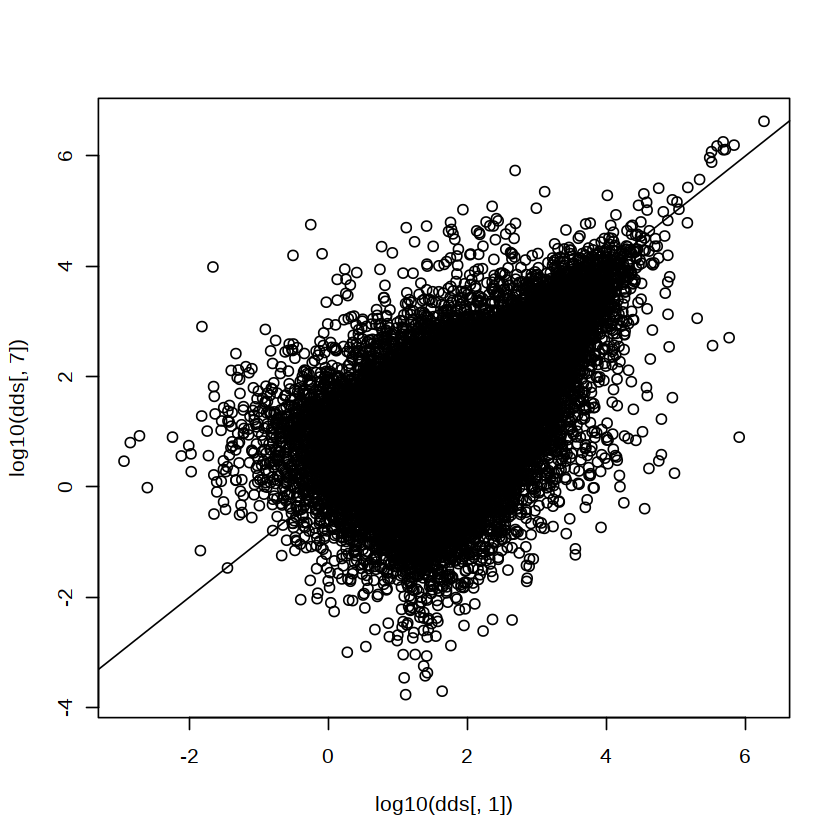

In [11]:
plot(log10(dds[,1]), log10(dds[,7])) + abline(0,1)

In [30]:
library(ggplot2)
library(ggpubr)
df <- data.frame(samp1 = log10(dds[,1]), samp2 = log10(dds[,7]))
p1 <- ggplot(df, aes(x=samp1)) + geom_histogram() + geom_vline(xintercept = median(df$samp1),        # Add line for mean
             col = "red",
             lwd = 1)
p2 <- ggplot(df, aes(x=samp2)) + geom_histogram() + geom_vline(xintercept = median(df$samp2),        # Add line for mean
             col = "red",
             lwd = 1)
print(median(df$samp1))
print(median(df$samp2))

[1] 1.733611
[1] 1.210719


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



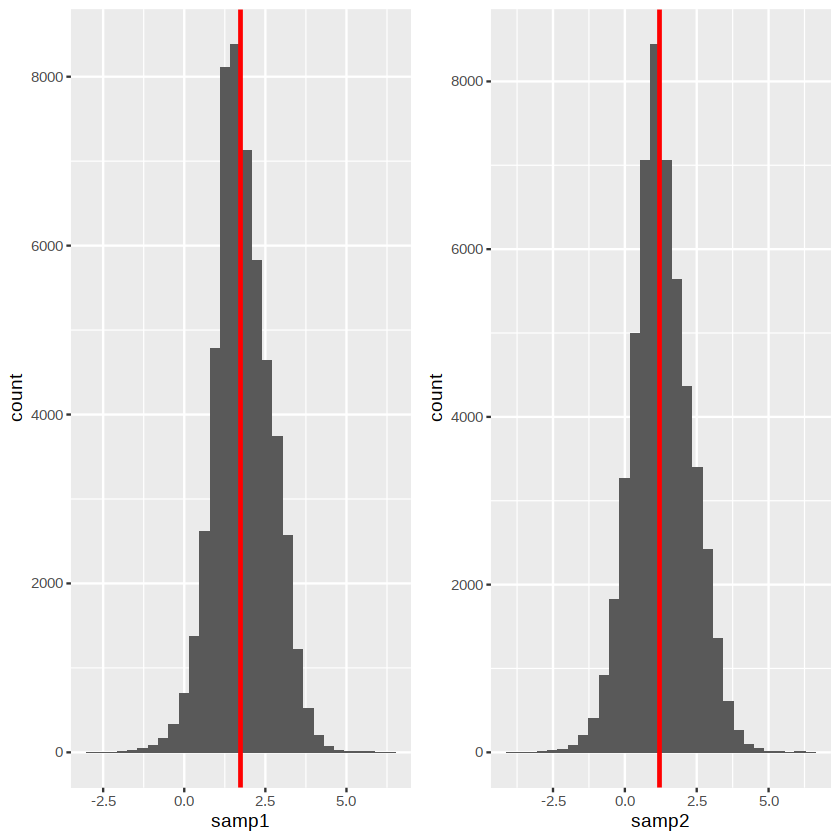

In [31]:
ggarrange(p1,p2)

integer(0)

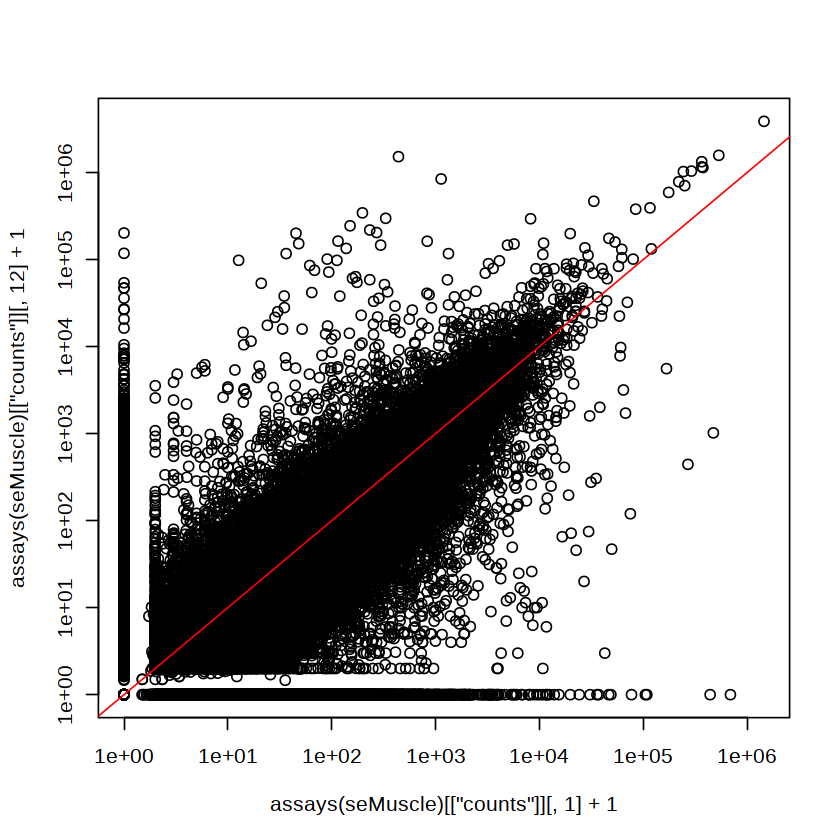

In [3]:
plot(assays(seMuscle)[["counts"]][,1]+1, assays(seMuscle)[["counts"]][,12]+1, log="xy") + abline(0,1,col="red")